In [70]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_ethnicity_confusion_matrices(predictions, true_labels, ethnicity):
    data = pd.DataFrame({
        'true_label': true_labels,
        'predicted_label': predictions,
        'ethnicity': ethnicity
    })

    # get labels and ethnicities
    labels = sorted(data['true_label'].unique())
    ethnicities = ['AF', 'WE', 'EA', 'BA', 'H', 'WA']

    for eth in ethnicities:
        # separate the data based on ethnicity
        eth_data = data[data['ethnicity'] == eth]

        # compute confusion matrix for current ethnicity
        eth_cm = confusion_matrix(eth_data['true_label'], eth_data['predicted_label'], labels=labels)
        print(f"Confusion Matrix for {eth}:\n", eth_cm)

        # display confusion matrix for current ethnicity
        eth_disp = ConfusionMatrixDisplay(confusion_matrix=eth_cm, display_labels=labels)
        eth_disp.plot()
        plt.title(f"Confusion Matrix for {eth}")
        plt.show()

In [71]:
import pandas as pd

def demographic_parity_difference(predictions, true_labels, ethnicity):
    data = pd.DataFrame({
        'true_label': true_labels,
        'predicted_label': predictions,
        'ethnicity': ethnicity
    })
    
    # get labels and ethnicities
    labels = sorted(data['true_label'].unique())
    ethnicities = sorted(data['ethnicity'].unique())
    
    # init dicts
    privileged_ethnicities = {}
    unprivileged_ethnicities = {}
    dpd_values = {}
    ranked_ethnicities = {}
    
    for label in labels:
        ethnicity_positive_rates = {}
        
        for eth in ethnicities:
            # separate data by ethnicity
            eth_data = data[data['ethnicity'] == eth]
            total_eth_items = len(eth_data)
            
            # find number of positive preds for current label
            positives = (eth_data['predicted_label'] == label).sum()
            # compute positive rate for current ethnicity
            eth_positive_rate = positives / total_eth_items if total_eth_items > 0 else 0
            
            # store positive rate
            ethnicity_positive_rates[eth] = eth_positive_rate

        # determine privileged and unprivileged ethnicities for current label
        expected_privileged = (ethnicity_positive_rates['WA'] + ethnicity_positive_rates['EA'] + ethnicity_positive_rates['WE'])/3
        expected_unprivileged = (ethnicity_positive_rates['H'] + ethnicity_positive_rates['BA'] + ethnicity_positive_rates['AF'])/3

        if expected_privileged > expected_unprivileged:
            privileged_ethnicities[label] = "WA, WE, EA"
            unprivileged_ethnicities[label] = "H, BA, AF"
        else: 
            privileged_ethnicities[label] = "H, BA, AF"
            unprivileged_ethnicities[label] = "WA, WE, EA"
            
        
        # compute dpd for current label
        dpd = abs(expected_privileged - expected_unprivileged)
        dpd_values[label] = dpd
        
        # rank ethnicities by positive rates
        ranked_ethnicity_list = sorted(ethnicity_positive_rates, key=ethnicity_positive_rates.get, reverse=True)
        ranked_ethnicities[label] = ranked_ethnicity_list


    return dpd_values, privileged_ethnicities, unprivileged_ethnicities, ranked_ethnicities


In [72]:
import pandas as pd

def equal_opportunity_difference(predictions, true_labels, ethnicity):
    data = pd.DataFrame({
        'true_label': true_labels,
        'predicted_label': predictions,
        'ethnicity': ethnicity
    })
    
    # get unique labels and unique ethnicities
    labels = sorted(data['true_label'].unique())
    ethnicities = sorted(data['ethnicity'].unique())
    
    # init dicts
    eod_dict = {}
    privileged_ethnicities = {}
    unprivileged_ethnicities = {}
    ranked_ethnicities = {}

    
    for label in labels:
        # init dicts
        ethnicity_true_positives = {}
        ethnicity_condition_positives = {}
        ethnicity_recalls = {}
        
        for eth in ethnicities:
            # separate data by ethnicity
            eth_data = data[data['ethnicity'] == eth]
            
            # count true positives and condition positives for current ethnicity
            eth_true_positives = ((eth_data['true_label'] == label) & (eth_data['predicted_label'] == label)).sum()
            eth_condition_positives = (eth_data['true_label'] == label).sum()
            
            # compute TPR for current ethnicity
            eth_recall = eth_true_positives / eth_condition_positives if eth_condition_positives != 0 else 0
            
            # store true positives, condition positives, and recall
            ethnicity_true_positives[eth] = eth_true_positives
            ethnicity_condition_positives[eth] = eth_condition_positives
            ethnicity_recalls[eth] = eth_recall
        
        # determine privileged and unprivileged ethnicity for current label
        expected_privileged = (ethnicity_recalls['WA'] + ethnicity_recalls['EA'] + ethnicity_recalls['WE'])/3
        expected_unprivileged = (ethnicity_recalls['H'] + ethnicity_recalls['BA'] + ethnicity_recalls['AF'])/3

        if expected_privileged > expected_unprivileged:
            privileged_ethnicities[label] = "WA, WE, EA"
            unprivileged_ethnicities[label] = "H, BA, AF"
        else: 
            privileged_ethnicities[label] = "H, BA, AF"
            unprivileged_ethnicities[label] = "WA, WE, EA"
                
        # compute eod for current label (as difference between first and last ranked)
        eod = abs(expected_privileged - expected_unprivileged)
        eod_dict[label] = eod
        

        ranked_ethnicity_list = sorted(ethnicity_recalls, key=ethnicity_recalls.get, reverse=True)
        ranked_ethnicities[label] = ranked_ethnicity_list


    return eod_dict, privileged_ethnicities, unprivileged_ethnicities, ranked_ethnicities

In [73]:
import pandas as pd

def average_odds_difference(predictions, true_labels, ethnicity):
    data = pd.DataFrame({
        'true_label': true_labels,
        'predicted_label': predictions,
        'ethnicity': ethnicity
    })
    
    # get labels and ethnicities
    labels = sorted(data['true_label'].unique())
    ethnicities = sorted(data['ethnicity'].unique())
    
    # init dicts
    aod_dict = {}
    privileged_ethnicities = {}
    unprivileged_ethnicities = {}
    ranked_ethnicities = {}
    privilege = {}

    for label in labels:
        # init dicts
        ethnicity_tprs = {}
        ethnicity_fprs = {}
        
        for eth in ethnicities:
            # separate data by ethnicity
            eth_data = data[data['ethnicity'] == eth]
            
            # count true positives and condition positives for current ethnicity
            eth_true_positives = ((eth_data['true_label'] == label) & (eth_data['predicted_label'] == label)).sum()
            eth_condition_positives = (eth_data['true_label'] == label).sum()
            
            # compute TPR for current ethnicity
            eth_tpr = eth_true_positives / eth_condition_positives if eth_condition_positives != 0 else 0
            
            # count false positives and condition negatives for current ethnicity
            eth_false_positives = ((eth_data['true_label'] != label) & (eth_data['predicted_label'] == label)).sum()
            eth_condition_negatives = (eth_data['true_label'] != label).sum()
            
            # compute FPR for the current ethnicity
            eth_fpr = eth_false_positives / eth_condition_negatives if eth_condition_negatives != 0 else 0
            
            # store TPR and FPR
            ethnicity_tprs[eth] = eth_tpr
            ethnicity_fprs[eth] = eth_fpr

            privilege[eth] = ethnicity_tprs[eth] + ethnicity_fprs[eth]
        
        # determine privileged and unprivileged ethnicity for current label
        expected_privileged = (privilege['WA'] + privilege['EA'] + privilege['WE'])/3
        expected_unprivileged = (privilege['H'] + privilege['BA'] + privilege['AF'])/3

        if expected_privileged > expected_unprivileged:
            privileged_ethnicities[label] = "WA, WE, EA"
            privileged_avg_tprs = (ethnicity_tprs['WA'] + ethnicity_tprs['WE'] + ethnicity_tprs['EA'])/3
            privileged_avg_fprs = (ethnicity_fprs['WA'] + ethnicity_fprs['WE'] + ethnicity_fprs['EA'])/3
            unprivileged_ethnicities[label] = "H, BA, AF"
            unprivileged_avg_tprs = (ethnicity_tprs['H'] + ethnicity_tprs['BA'] + ethnicity_tprs['AF'])/3
            unprivileged_avg_fprs = (ethnicity_fprs['H'] + ethnicity_fprs['BA'] + ethnicity_fprs['AF'])/3


        else: 
            privileged_ethnicities[label] = "L, BA, AF"
            privileged_avg_tprs = (ethnicity_tprs['H'] + ethnicity_tprs['BA'] + ethnicity_tprs['AF'])/3
            privileged_avg_fprs = (ethnicity_fprs['H'] + ethnicity_fprs['BA'] + ethnicity_fprs['AF'])/3
            unprivileged_ethnicities[label] = "WA, WE, A"
            unprivileged_avg_tprs = (ethnicity_tprs['WA'] + ethnicity_tprs['WE'] + ethnicity_tprs['EA'])/3
            unprivileged_avg_fprs = (ethnicity_fprs['WA'] + ethnicity_fprs['WE'] + ethnicity_fprs['EA'])/3

        # compute AOD for current label
        aod = 0.5 * (abs(unprivileged_avg_fprs - privileged_avg_fprs) + abs(unprivileged_avg_tprs - privileged_avg_tprs))
        
        # store results
        aod_dict[label] = aod

        ranked_ethnicity_list = sorted(privilege, key=privilege.get, reverse=True)
        ranked_ethnicities[label] = ranked_ethnicity_list


    return aod_dict, privileged_ethnicities, unprivileged_ethnicities, ranked_ethnicities



In [74]:
import pandas as pd

def false_discovery_rate_difference(predictions, true_labels, ethnicity):
    data = pd.DataFrame({
        'true_label': true_labels,
        'predicted_label': predictions,
        'ethnicity': ethnicity
    })
    
    # Get unique labels and unique ethnicities
    labels = sorted(data['true_label'].unique())
    ethnicities = sorted(data['ethnicity'].unique())
    
    # Initialize dictionaries
    fdr_dict = {}
    privileged_ethnicities = {}
    unprivileged_ethnicities = {}
    ranked_ethnicities = {}
    
    for label in labels:
        # Initialize dictionaries
        ethnicity_false_positives = {}
        ethnicity_predicted_positives = {}
        ethnicity_fdrs = {}
        
        for eth in ethnicities:
            # Separate data by ethnicity
            eth_data = data[data['ethnicity'] == eth]
            
            # Count false positives and predicted positives for current ethnicity
            eth_false_positives = ((eth_data['true_label'] != label) & (eth_data['predicted_label'] == label)).sum()
            eth_predicted_positives = (eth_data['predicted_label'] == label).sum()
            
            # Compute FDR for current ethnicity
            eth_fdr = eth_false_positives / eth_predicted_positives if eth_predicted_positives != 0 else 0
            
            # Store false positives, predicted positives, and FDR
            ethnicity_false_positives[eth] = eth_false_positives
            ethnicity_predicted_positives[eth] = eth_predicted_positives
            ethnicity_fdrs[eth] = eth_fdr
        
        # Determine privileged and unprivileged ethnicity for current label
        expected_privileged = (ethnicity_fdrs['WA'] + ethnicity_fdrs['EA'] + ethnicity_fdrs['WE'])/3
        expected_unprivileged = (ethnicity_fdrs['H'] + ethnicity_fdrs['BA'] + ethnicity_fdrs['AF'])/3

        if expected_privileged > expected_unprivileged:
            privileged_ethnicities[label] = "WA, WE, EA"
            unprivileged_ethnicities[label] = "H, BA, AF"
        else: 
            privileged_ethnicities[label] = "H, BA, AF"
            unprivileged_ethnicities[label] = "WA, WE, EA"
            
        # Compute FDR for current label (as difference between first and last ranked)
        fdr_diff = abs(expected_privileged - expected_unprivileged)
        
        # Store results
        fdr_dict[label] = fdr_diff

        ranked_ethnicity_list = sorted(ethnicity_fdrs, key=ethnicity_fdrs.get, reverse=True)
        ranked_ethnicities[label] = ranked_ethnicity_list


    return fdr_dict, privileged_ethnicities, unprivileged_ethnicities, ranked_ethnicities


In [75]:
def false_omission_rate_difference(predictions, true_labels, ethnicity):
    data = pd.DataFrame({
        'true_label': true_labels,
        'predicted_label': predictions,
        'ethnicity': ethnicity
    })
    
    # Get unique labels and unique ethnicities
    labels = sorted(data['true_label'].unique())
    ethnicities = sorted(data['ethnicity'].unique())
    
    # Initialize dictionaries
    for_dict = {}
    privileged_ethnicities = {}
    unprivileged_ethnicities = {}
    ranked_ethnicities = {}
    
    for label in labels:
        # Initialize dictionaries
        ethnicity_false_negatives = {}
        ethnicity_condition_negatives = {}
        ethnicity_fors = {}
        
        for eth in ethnicities:
            # Separate data by ethnicity
            eth_data = data[data['ethnicity'] == eth]
            
            # Count false negatives and condition negatives for current ethnicity
            eth_false_negatives = ((eth_data['true_label'] == label) & (eth_data['predicted_label'] != label)).sum()
            eth_condition_negatives = (eth_data['true_label'] == label).sum()
            
            # Compute FOR for current ethnicity
            eth_for = eth_false_negatives / eth_condition_negatives if eth_condition_negatives != 0 else 0
            
            # Store false negatives, condition negatives, and FOR
            ethnicity_false_negatives[eth] = eth_false_negatives
            ethnicity_condition_negatives[eth] = eth_condition_negatives
            ethnicity_fors[eth] = eth_for
        
        # Determine privileged and unprivileged ethnicity for current label
        expected_privileged = (ethnicity_fors['WA'] + ethnicity_fors['EA'] + ethnicity_fors['WE'])/3
        expected_unprivileged = (ethnicity_fors['H'] + ethnicity_fors['BA'] + ethnicity_fors['AF'])/3

        if expected_privileged < expected_unprivileged:
            privileged_ethnicities[label] = "WA, WE, EA"
            unprivileged_ethnicities[label] = "H, BA, AF"
        else: 
            privileged_ethnicities[label] = "H, BA, AF"
            unprivileged_ethnicities[label] = "WA, WE, EA"
            
        # Compute FOR for current label (as difference between first and last ranked)
        for_diff = abs(expected_privileged - expected_unprivileged)
        
        # Store results
        for_dict[label] = for_diff

        ranked_ethnicity_list = sorted(ethnicity_fors, key=ethnicity_fors.get)
        ranked_ethnicities[label] = ranked_ethnicity_list

    return for_dict, privileged_ethnicities, unprivileged_ethnicities, ranked_ethnicities



In [50]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


# load train and test datasets separately
datatrain = pd.read_csv('Data/ethnicity_biased_final.csv')
data_train = datatrain.sample(frac=0.8, random_state=42)

datatest = pd.read_csv('Data/balanced_resumes_final.csv')
data_test = datatest.sample(frac=0.2, random_state=42)

# drop rows with missing values in text columns
text_columns = ['Name', 'Education', 'Work Experience', 'Skills', 'Awards']
data_train = data_train.dropna(subset=text_columns)
data_test = data_test.dropna(subset=text_columns)

# extract text data and labels separately
X_train_text = data_train['Name'] + ' ' + data_train['Education'] + ' ' + data_train['Work Experience'] + ' ' + data_train['Skills'] + ' ' + data_train['Awards']
y_train = data_train['Fit']
gender_train = data_train['Gender']
ethnicity_train = data_train['Ethnicity']

X_test_text = data_test['Name'] + ' ' + data_test['Education'] + ' ' + data_test['Work Experience'] + ' ' + data_test['Skills'] + ' ' + data_test['Awards']
y_test = data_test['Fit']
gender_test = data_test['Gender']
ethnicity_test = data_test['Ethnicity']

# vectorize text data with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)


Accuracy: 0.5787401574803149
              precision    recall  f1-score   support

     average       0.57      0.51      0.54        69
         bad       0.59      0.60      0.59        40
        good       0.45      0.51      0.48        59
    very bad       0.80      0.76      0.78        37
   very good       0.60      0.61      0.61        49

    accuracy                           0.58       254
   macro avg       0.60      0.60      0.60       254
weighted avg       0.58      0.58      0.58       254

Confusion Matrix for AF:
 [[4 1 0 0 3]
 [0 3 0 2 0]
 [3 0 8 0 0]
 [0 0 0 7 0]
 [0 0 1 0 4]]


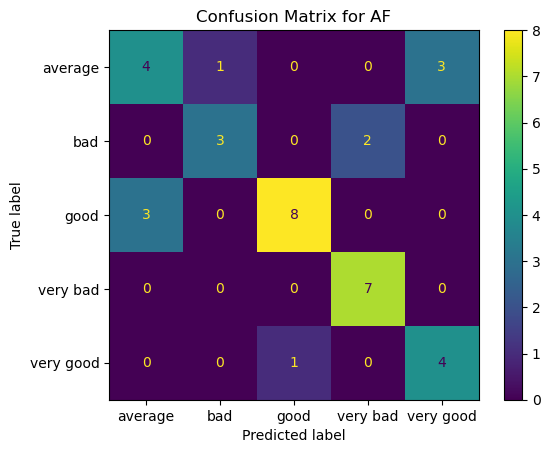

Confusion Matrix for WE:
 [[9 0 6 0 0]
 [5 6 0 1 0]
 [2 1 4 0 5]
 [0 4 0 2 0]
 [1 0 2 0 9]]


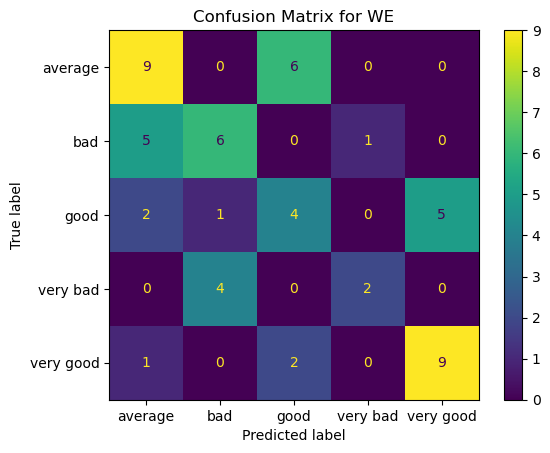

Confusion Matrix for EA:
 [[4 0 6 0 0]
 [2 3 0 0 0]
 [0 0 5 0 2]
 [0 1 0 3 0]
 [0 0 1 0 4]]


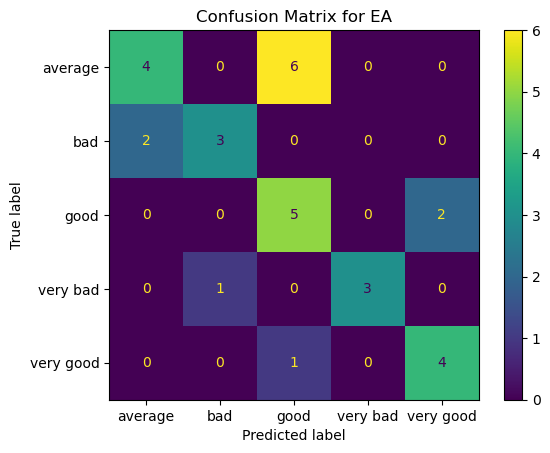

Confusion Matrix for BA:
 [[5 3 1 0 1]
 [0 6 0 1 0]
 [4 0 2 0 1]
 [1 0 0 7 0]
 [0 0 8 0 3]]


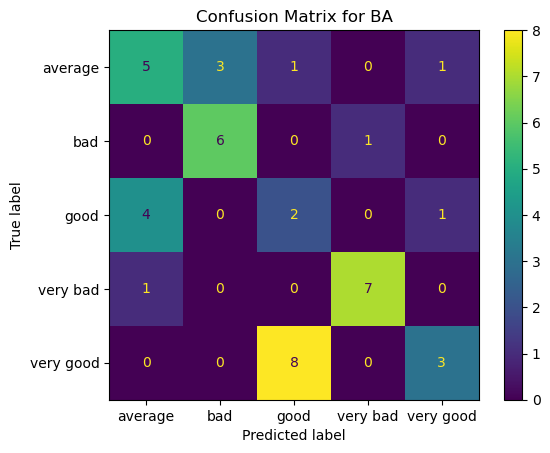

Confusion Matrix for H:
 [[7 4 2 0 2]
 [0 2 0 3 0]
 [3 0 6 0 1]
 [0 0 0 5 0]
 [0 0 3 0 3]]


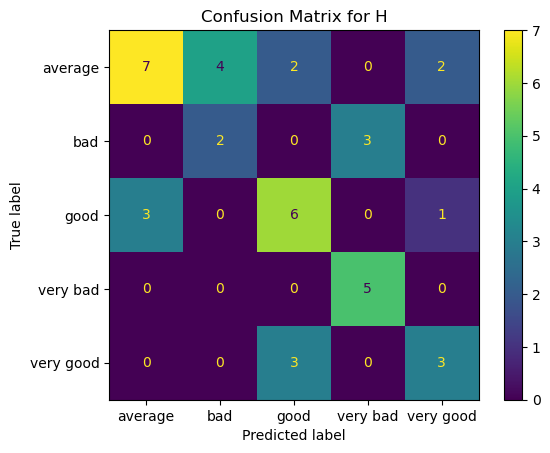

Confusion Matrix for WA:
 [[6 0 4 0 1]
 [2 4 0 0 0]
 [3 0 5 0 4]
 [0 3 0 4 0]
 [0 0 3 0 7]]


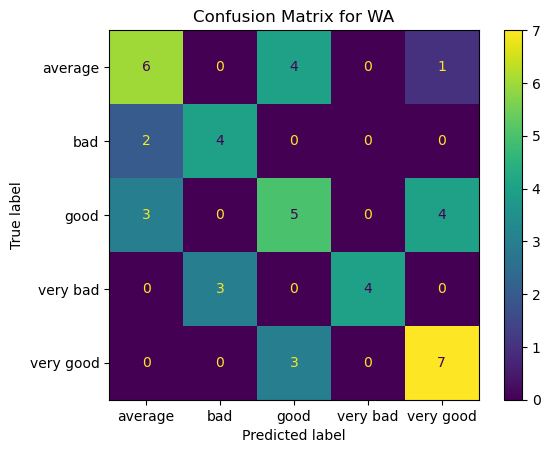

In [52]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

n_iterations = 10  # nr of bootstrap samples
n_size = X_train.shape[0]  # nr of samples in the training set

# convert y_train to a numpy array
y_train_array = y_train.to_numpy()

# list to store accuracy for each bootstrap sample
bootstrap_svm = {}

# bootstrap resampling
for i in range(n_iterations):
    # generate bootstrap sample
    indices = np.random.choice(np.arange(n_size), size=n_size, replace=True)
    X_train_resample = X_train[indices]
    y_train_resample = y_train_array[indices]
    
    
    # train SVM model on bootstrap sample
    svm_classifier = SVC(kernel='linear', C=1.7)
    svm_classifier.fit(X_train_resample, y_train_resample)
    
    # predict on test set
    y_pred_svm = svm_classifier.predict(X_test)
    bootstrap_svm[i] = y_pred_svm
    
accuracy = accuracy_score(y_test, bootstrap_svm[0])
print("Accuracy:", accuracy)
print(classification_report(y_test, bootstrap_svm[0]))
plot_ethnicity_confusion_matrices(bootstrap_svm[0], y_test, ethnicity_test)


Accuracy: 0.5748031496062992
              precision    recall  f1-score   support

     average       0.54      0.43      0.48        69
         bad       0.60      0.53      0.56        40
        good       0.52      0.49      0.50        59
    very bad       0.74      0.76      0.75        37
   very good       0.55      0.78      0.64        49

    accuracy                           0.57       254
   macro avg       0.59      0.60      0.59       254
weighted avg       0.57      0.57      0.57       254

Confusion Matrix for AF:
 [[5 1 0 0 2]
 [0 3 0 2 0]
 [4 0 6 0 1]
 [0 1 0 6 0]
 [0 0 1 0 4]]


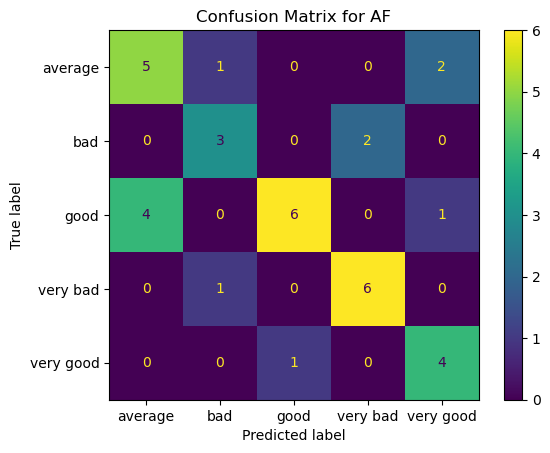

Confusion Matrix for WE:
 [[ 5  0  7  0  3]
 [ 4  7  0  1  0]
 [ 1  0  6  0  5]
 [ 0  3  0  3  0]
 [ 1  0  1  0 10]]


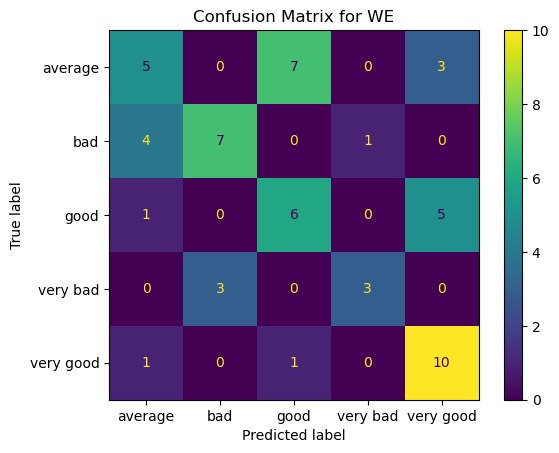

Confusion Matrix for EA:
 [[3 0 6 0 1]
 [2 2 0 0 1]
 [0 0 6 0 1]
 [0 2 0 2 0]
 [0 0 1 0 4]]


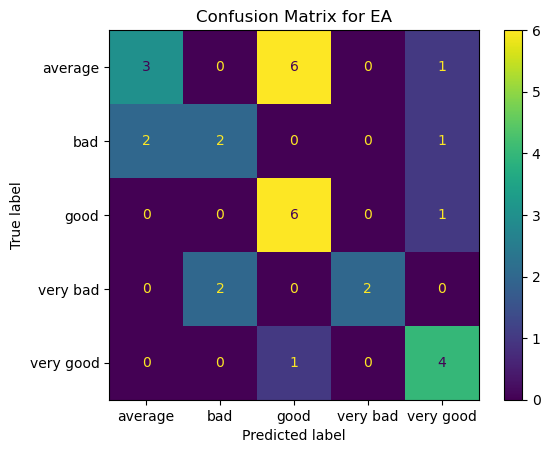

Confusion Matrix for BA:
 [[4 2 1 0 3]
 [1 5 0 1 0]
 [3 0 3 0 1]
 [2 0 0 6 0]
 [1 0 3 0 7]]


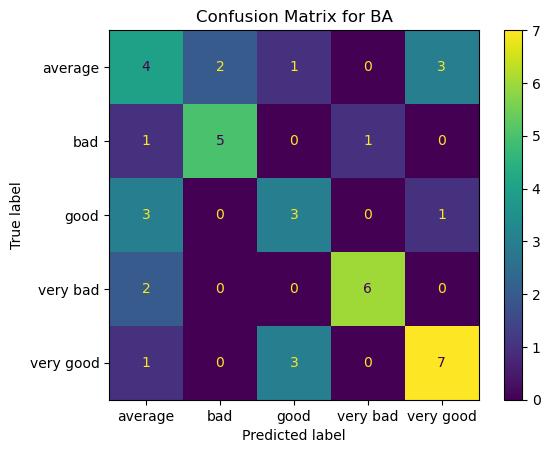

Confusion Matrix for H:
 [[8 3 0 0 4]
 [0 1 0 4 0]
 [2 0 6 0 2]
 [0 0 0 5 0]
 [0 0 2 0 4]]


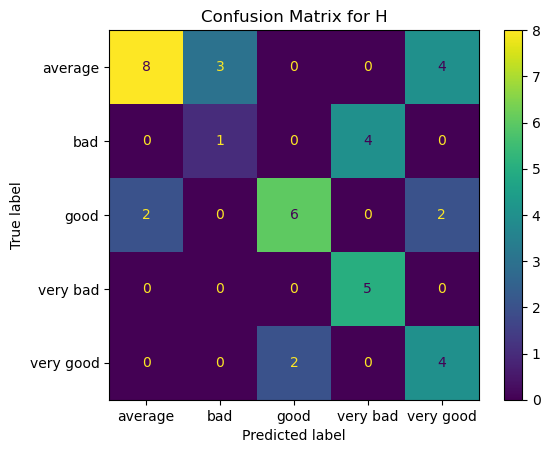

Confusion Matrix for WA:
 [[5 0 5 0 1]
 [1 3 0 2 0]
 [3 1 2 0 6]
 [0 1 0 6 0]
 [1 0 0 0 9]]


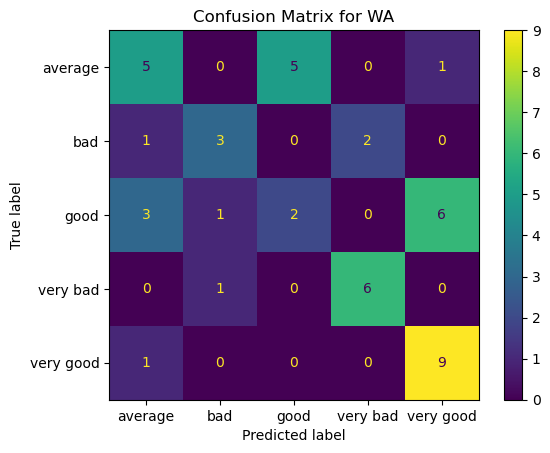

In [53]:
n_iterations = 10  # Number of bootstrap samples
n_size = X_train.shape[0]  # Number of samples in the training set

# convert y_train to a numpy array
y_train_array = y_train.to_numpy()

# list to store accuracy for each bootstrap sample
bootstrap_lr = {}

# bootstrap resampling
for i in range(n_iterations):
    # generate bootstrap sample
    indices = np.random.choice(np.arange(n_size), size=n_size, replace=True)
    X_train_resample = X_train[indices]
    y_train_resample = y_train_array[indices]
    
    
    # train SVM model on bootstrap sample
    logistic_classifier = LogisticRegression(max_iter=1000)
    logistic_classifier.fit(X_train_resample, y_train_resample)
    
    # predict on the test set
    y_pred_lr = logistic_classifier.predict(X_test)
    bootstrap_lr[i] = y_pred_lr

accuracy = accuracy_score(y_test, bootstrap_lr[0])
print("Accuracy:", accuracy)
print(classification_report(y_test, bootstrap_lr[0]))
plot_ethnicity_confusion_matrices(bootstrap_lr[0], y_test, ethnicity_test)


Accuracy: 0.594488188976378
              precision    recall  f1-score   support

     average       0.60      0.45      0.51        69
         bad       0.52      0.55      0.54        40
        good       0.47      0.58      0.52        59
    very bad       0.80      0.76      0.78        37
   very good       0.68      0.73      0.71        49

    accuracy                           0.59       254
   macro avg       0.61      0.61      0.61       254
weighted avg       0.60      0.59      0.59       254

Confusion Matrix for AF:
 [[6 0 2 0 0]
 [0 4 0 1 0]
 [3 0 7 0 1]
 [0 0 0 7 0]
 [0 0 0 0 5]]


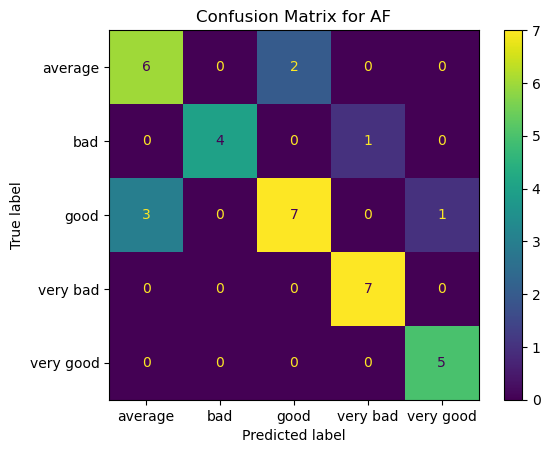

Confusion Matrix for WE:
 [[ 8  0  7  0  0]
 [ 6  6  0  0  0]
 [ 0  0  7  0  5]
 [ 0  2  0  4  0]
 [ 0  0  2  0 10]]


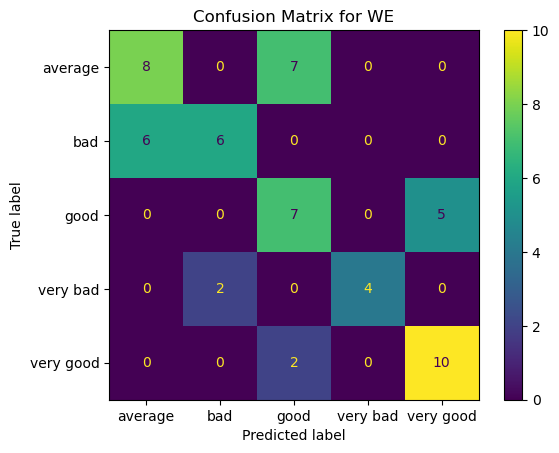

Confusion Matrix for EA:
 [[2 0 7 0 1]
 [3 2 0 0 0]
 [0 0 4 0 3]
 [0 3 0 1 0]
 [0 0 1 0 4]]


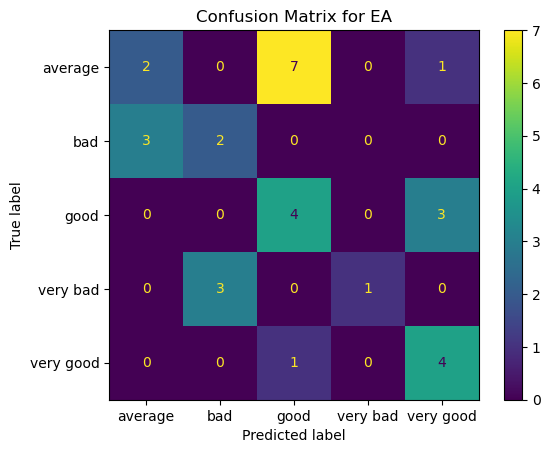

Confusion Matrix for BA:
 [[4 4 2 0 0]
 [0 5 0 2 0]
 [3 0 3 0 1]
 [0 2 0 6 0]
 [0 0 6 0 5]]


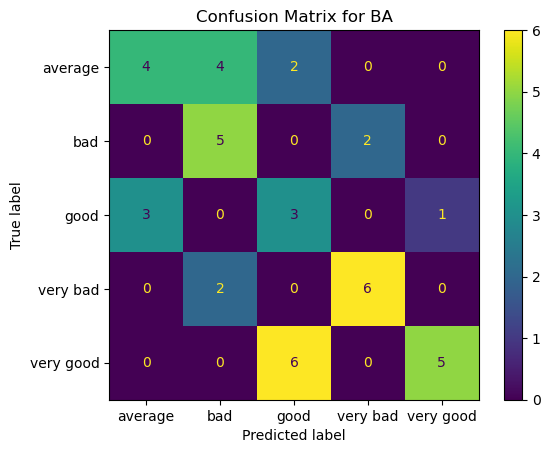

Confusion Matrix for H:
 [[6 7 2 0 0]
 [0 1 0 4 0]
 [4 0 5 0 1]
 [0 0 0 5 0]
 [0 0 2 0 4]]


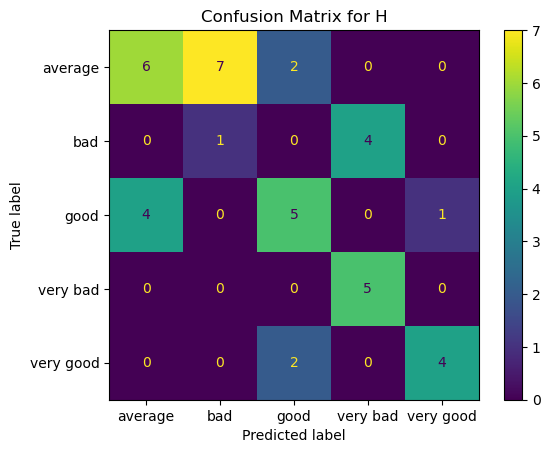

Confusion Matrix for WA:
 [[5 0 5 0 1]
 [2 4 0 0 0]
 [0 0 8 0 4]
 [0 2 0 5 0]
 [0 0 2 0 8]]


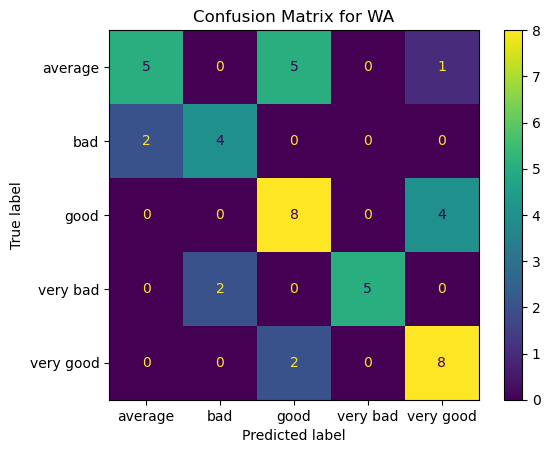

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

# list to store preds
bootstrap_rf = []

# generate 10 different sets of predictions
for i in range(10):
    # bootstrap sampling of the training data
    X_train_resampled, y_train_resampled = resample(X_train, y_train)
    
    # init classifier
    rf_classifier = RandomForestClassifier(n_estimators=90)
    
    # fit classifier on the resampled training data
    rf_classifier.fit(X_train_resampled, y_train_resampled)
    
    # pred on test set
    y_pred_rf = rf_classifier.predict(X_test)
    
    # append predictions to list
    bootstrap_rf.append(y_pred_rf.tolist())

accuracy = accuracy_score(y_test, bootstrap_rf[0])
print("Accuracy:", accuracy)
print(classification_report(y_test, bootstrap_rf[0]))
plot_ethnicity_confusion_matrices(bootstrap_rf[0], y_test, ethnicity_test)


Accuracy: 0.5866141732283464
              precision    recall  f1-score   support

     average       0.67      0.59      0.63        69
         bad       0.47      0.50      0.48        40
        good       0.49      0.42      0.45        59
    very bad       0.67      0.78      0.72        37
   very good       0.61      0.69      0.65        49

    accuracy                           0.59       254
   macro avg       0.58      0.60      0.59       254
weighted avg       0.59      0.59      0.58       254

Confusion Matrix for AF:
 [[7 1 0 0 0]
 [0 3 0 2 0]
 [4 0 3 0 4]
 [0 0 0 7 0]
 [0 0 1 0 4]]


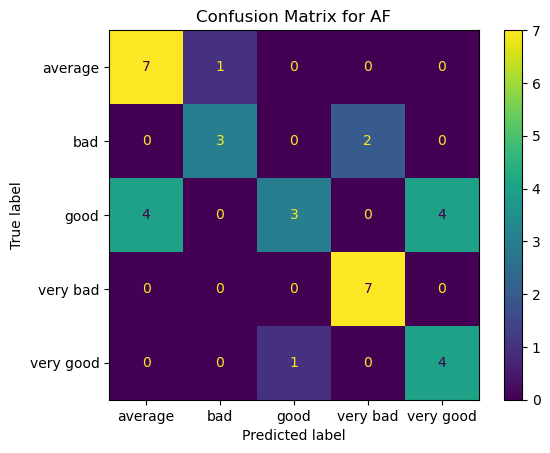

Confusion Matrix for WE:
 [[10  1  4  0  0]
 [ 4  7  0  1  0]
 [ 0  0  8  0  4]
 [ 0  4  0  2  0]
 [ 0  1  2  0  9]]


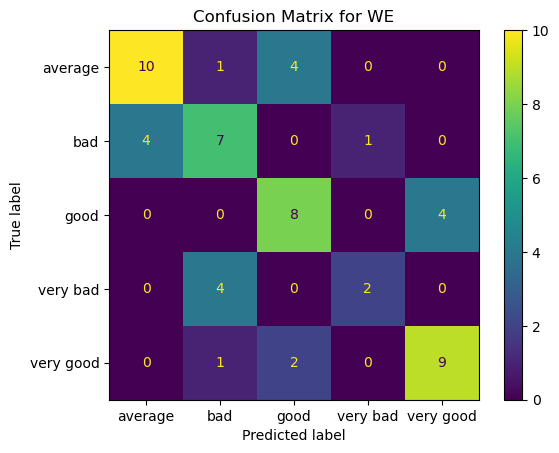

Confusion Matrix for EA:
 [[6 0 3 0 1]
 [1 3 0 1 0]
 [1 0 4 0 2]
 [0 1 0 3 0]
 [0 0 1 0 4]]


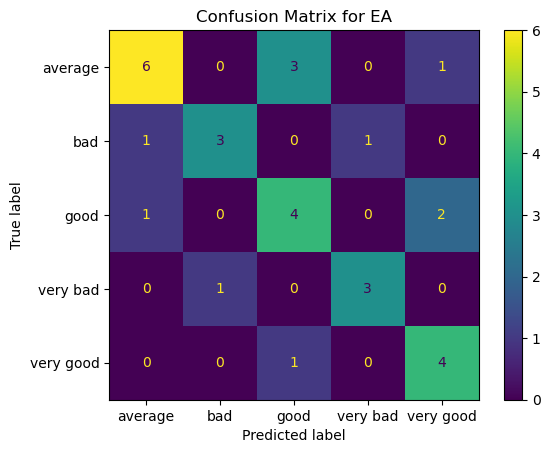

Confusion Matrix for BA:
 [[3 5 1 0 1]
 [0 3 0 4 0]
 [4 0 3 0 0]
 [0 0 0 8 0]
 [0 0 7 0 4]]


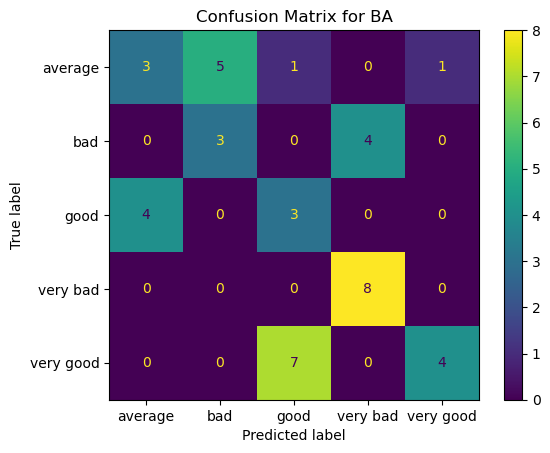

Confusion Matrix for H:
 [[8 6 0 0 1]
 [0 1 0 4 0]
 [4 0 2 0 4]
 [0 0 0 5 0]
 [0 0 2 0 4]]


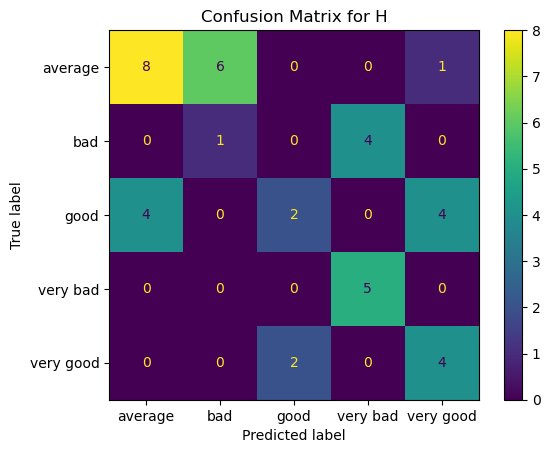

Confusion Matrix for WA:
 [[7 0 4 0 0]
 [1 3 0 2 0]
 [1 1 5 0 5]
 [0 3 0 4 0]
 [0 0 1 0 9]]


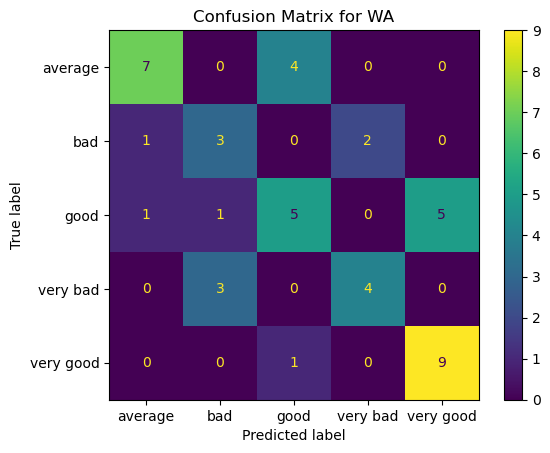

In [55]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import resample

# list to store preds
bootstrap_gb = []

# generate 10 different sets of predictions
for i in range(10):
    # bootstrap sampling of training data
    X_train_resampled, y_train_resampled = resample(X_train, y_train, random_state=i)
    
    # initialize classifier
    gb_classifier = GradientBoostingClassifier(n_estimators=90)
    
    # fit classifier on the resampled training data
    gb_classifier.fit(X_train_resampled, y_train_resampled)
    
    # predict on the test set
    y_pred_gb = gb_classifier.predict(X_test)
    
    # append preds to the list
    bootstrap_gb.append(y_pred_gb.tolist())

accuracy = accuracy_score(y_test, bootstrap_gb[0])
print("Accuracy:", accuracy)
print(classification_report(y_test, bootstrap_gb[0]))
plot_ethnicity_confusion_matrices(bootstrap_gb[0], y_test, ethnicity_test)


In [56]:
from tabulate import tabulate

# aggregates scores of the 5 metrics
def process_data(tuples):
    scores = {}
    privileged_ethnicities = {}
    unprivileged_ethnicities = {}
    ranking = {}

    # def list of labels and metrics
    labels = ['average', 'bad', 'good', 'very bad', 'very good']
    metrics = ['DPD', 'EOD', 'AOD', 'FDR', 'FOR']

    # init lists to store the scores and privileged genders
    for label in labels:
        scores[label] = []
        privileged_ethnicities[label] = []
        unprivileged_ethnicities[label] = []
        ranking[label] = []

    # loop through the tuples
    for t in tuples:
        for label in labels:
            scores[label].extend(t[0][label]) if isinstance(t[0][label], list) else scores[label].append(t[0][label])
            privileged_ethnicities[label].extend(t[1][label]) if isinstance(t[1][label], list) else privileged_ethnicities[label].append(t[1][label])
            unprivileged_ethnicities[label].extend(t[2][label]) if isinstance(t[2][label], list) else unprivileged_ethnicities[label].append(t[2][label])
            ranking[label].append(t[3][label])

    return scores, privileged_ethnicities, unprivileged_ethnicities, ranking

# prints tables with the specific per-metric bias scores
def print_tables(scores, privileged_ethnicities, unprivileged_ethnicities, ranking):
    labels = ['average', 'good', 'bad', 'very good', 'very bad']
    metrics = ['DPD', 'EOD', 'AOD', 'FDR', 'FOR']

    for label in labels:
        data = []
        for i, score in enumerate(scores[label]):
            data.append([metrics[i], score, privileged_ethnicities[label][i], unprivileged_ethnicities[label][i], ranking[label][i]])
        print(f"Table for label '{label}':")
        print(tabulate(data, headers=['Metric', 'Value', 'Privileged Ethnicity', 'Unprivileged Ethnicity', 'Ranking'], tablefmt='grid', numalign='left'))
        print("\n")

In [57]:
# compute weighted sum of the 5 bias scores for each ethnicity -> will be used for the average of metrics, but divided by 5 later
def compute_ethnicity_weighted_sums(list_of_dict_pairs):
    
    # initialize a dict to store the sums for each label
    label_sums = {}

    # Iterate over each list of dictionary pairs
    for dict_pair in list_of_dict_pairs:
        values_dict, ethnicity_dict, a, b = dict_pair
        
        # Iterate over each label in the values dictionary
        for label, value in values_dict.items():
            # Determine the gender and adjust the sum accordingly
            ethnicity_group = ethnicity_dict[label]
            if ethnicity_group == 'WA, WE, EA':
                label_sums[label] = label_sums.get(label, 0) + value
            elif ethnicity_group == 'H, BA, AF':
                label_sums[label] = label_sums.get(label, 0) - value

    return label_sums

# computes weighted sum per ethnicity based on label advantage
def compute_weighted_sums(data):
    # define the weights
    weights = {
        'very bad': -2,
        'bad': -1,
        'average': 0,
        'good': 1,
        'very good': 2
    }
    
    waweea_sum = 0
    hbaaf_sum = 0
    
    # iterate over the data
    for label, value in data.items():
        weight = weights.get(label, 0)  # get weight for current label
        
        if value < 0:  # if value is negative, add to sum for group1 
            waweea_sum += abs(value) * weight
        elif value > 0:  # if value is positive, add to sum for group2
            hbaaf_sum += value * weight

    
    return waweea_sum, hbaaf_sum



In [76]:
n = 0 #code below ran for n between 0 and 10 for the 10 runs, for each model

# computes all metrics for the n-th set of predictions
dpd_svm = demographic_parity_difference(bootstrap_svm[n], y_test, ethnicity_test)
eod_svm = equal_opportunity_difference(bootstrap_svm[n], y_test, ethnicity_test)
aod_svm = average_odds_difference(bootstrap_svm[n], y_test, ethnicity_test)
fdr_svm = false_discovery_rate_difference(bootstrap_svm[n], y_test, ethnicity_test)
for_svm = false_omission_rate_difference(bootstrap_svm[n], y_test, ethnicity_test)

# puts all metrics into one variable
tuples_svm = (dpd_svm, eod_svm, aod_svm, fdr_svm, for_svm)

# dpd_lr = demographic_parity_difference(bootstrap_lr[n], y_test, ethnicity_test)
# eod_lr = equal_opportunity_difference(bootstrap_lr[n], y_test, ethnicity_test)
# aod_lr = average_odds_difference(bootstrap_lr[n], y_test, ethnicity_test)
# fdr_lr = false_discovery_rate_difference(bootstrap_lr[n], y_test, ethnicity_test)
# for_lr = false_omission_rate_difference(bootstrap_lr[n], y_test, ethnicity_test)
# tuples_lr = (dpd_lr, eod_lr, aod_lr, fdr_lr, for_lr)


# dpd_rf = demographic_parity_difference(bootstrap_rf[n], y_test, ethnicity_test)
# eod_rf = equal_opportunity_difference(bootstrap_rf[n], y_test, ethnicity_test)
# aod_rf = average_odds_difference(bootstrap_rf[n], y_test, ethnicity_test)
# fdr_rf = false_discovery_rate_difference(bootstrap_rf[n], y_test, ethnicity_test)
# for_rf = false_omission_rate_difference(bootstrap_rf[n], y_test, ethnicity_test)
# tuples_rf = (dpd_rf, eod_rf, aod_rf, fdr_rf, for_rf)


# dpd_gb = demographic_parity_difference(bootstrap_gb[n], y_test, ethnicity_test)
# eod_gb = equal_opportunity_difference(bootstrap_gb[n], y_test, ethnicity_test)
# aod_gb = average_odds_difference(bootstrap_gb[n], y_test, ethnicity_test)
# fdr_gb = false_discovery_rate_difference(bootstrap_gb[n], y_test, ethnicity_test)
# for_gb = false_omission_rate_difference(bootstrap_gb[n], y_test, ethnicity_test)
# tuples_gb = (dpd_gb, eod_gb, aod_gb, fdr_gb, for_gb)

In [77]:
# for each metric, prints value, privileged and unprivileged ethnicity, and ranking of ethnicities from least to most privileged
print('SVM')
scores_svm, privileged_svm, unprivileged_svm, ranking = process_data(tuples_svm)
print_tables(scores_svm, privileged_svm, unprivileged_svm, ranking)

# print('LR')
# scores_lr, privileged_lr, unprivileged_lr, ranking = process_data(tuples_lr)
# print_tables(scores_lr, privileged_lr, unprivileged_lr, ranking)

# print('RF')
# scores_rf, privileged_rf, unprivileged_rf, ranking = process_data(tuples_rf)
# print_tables(scores_rf, privileged_rf, unprivileged_rf, ranking)

# print('GB')
# scores_gb, privileged_gb, unprivileged_gb, ranking = process_data(tuples_gb)
# print_tables(scores_gb, privileged_gb, unprivileged_gb, ranking)

SVM
Table for label 'average':
+----------+-----------+------------------------+--------------------------+-------------------------------------+
| Metric   | Value     | Privileged Ethnicity   | Unprivileged Ethnicity   | Ranking                             |
+==========+===========+========================+==========================+=====================================+
| DPD      | 0.0200065 | WA, WE, EA             | H, BA, AF                | ['WE', 'H', 'WA', 'BA', 'AF', 'EA'] |
+----------+-----------+------------------------+--------------------------+-------------------------------------+
| EOD      | 0.0262626 | WA, WE, EA             | H, BA, AF                | ['WE', 'WA', 'AF', 'BA', 'H', 'EA'] |
+----------+-----------+------------------------+--------------------------+-------------------------------------+
| AOD      | 0.0222194 | WA, WE, EA             | H, BA, AF                | ['WE', 'WA', 'BA', 'AF', 'H', 'EA'] |
+----------+-----------+------------------------+

In [78]:
result_svm = compute_ethnicity_weighted_sums(tuples_svm) # computes metric average for each ethnicity
print(result_svm)
weighted_sums = compute_weighted_sums(result_svm) # computes weighted sum per ethnicity based on label advantage
print(weighted_sums)
diff = abs(weighted_sums[0] - weighted_sums[1]) # diff in privilege between ethnicities
print('SVM')
print(diff/5) # now divided by 5 as it wasn't possible before due to the dictionary format
if weighted_sums[0] > weighted_sums[1]: # prints the privileged ethnicity
    print('WA, WE, EA')
else:
    print('H, BA, AF')

# result_lr = compute_metric_avg_per_ethnicity(tuples_lr) # computes metric average for each ethnicity
# weighted_sums = compute_weighted_sums(result_lr) # computes weighted sum per ethnicity based on label advantage
# diff = abs(weighted_sums[0] - weighted_sums[1]) # diff in privilege between ethnicities
# print('SVM')
# print(diff/5) # now divided by 5 as it wasn't possible before due to the dictionary format
# if weighted_sums[0] > weighted_sums[1]: # prints the privileged ethnicity
#     print('WA, WE, EA')
# else:
#     print('H, BA, AF')

# result_rf = compute_metric_avg_per_ethnicity(tuples_rf) # computes metric average for each ethnicity
# weighted_sums = compute_weighted_sums(result_rf) # computes weighted sum per ethnicity based on label advantage
# diff = abs(weighted_sums[0] - weighted_sums[1]) # diff in privilege between ethnicities
# print('SVM')
# print(diff/5) # now divided by 5 as it wasn't possible before due to the dictionary format
# if weighted_sums[0] > weighted_sums[1]: # prints the privileged ethnicity
#     print('WA, WE, EA')
# else:
#     print('H, BA, AF')

# result_gb = compute_metric_avg_per_ethnicity(tuples_gb) # computes metric average for each ethnicity
# weighted_sums = compute_weighted_sums(result_gb) # computes weighted sum per ethnicity based on label advantage
# diff = abs(weighted_sums[0] - weighted_sums[1]) # diff in privilege between ethnicities
# print('SVM')
# print(diff/5) # now divided by 5 as it wasn't possible before due to the dictionary format
# if weighted_sums[0] > weighted_sums[1]: # prints the privileged ethnicity
#     print('WA, WE, EA')
# else:
#     print('H, BA, AF')



{'average': 0.10471636891544261, 'bad': -0.09680059023143114, 'good': 0.1409490858769005, 'very bad': -1.074723749325871, 'very good': 0.5852291851196043}
(-2.2462480888831733, 1.311407456116109)
SVM
0.7115311089998565
H, BA, AF


In [82]:
import numpy as np

# positive values represent predicitons where the male candidates are privileged. When female candidates are privileged, they keep their absolute value but become negative
l = [0.6589482613370713, 0.9934564540287084, 0.8800857798299354, 0.6676379992589274, 0.6602748627376511,
     0.881157271975294, 0.8765420920313793, 0.69195658882815, 0.8790023360427899, 0.6719486586079777]

sample_standard_deviation = np.std(l, ddof=1)  # sample standard deviation with Bessel's correction
sem = sample_standard_deviation / np.sqrt(10)

# prints standard deviation for the bias measure, /6 for normalisation
print('margin of error for bias:')
print(sem/6)

# prints mean of values, /6 for normalisation
print('mean of bias value:')
print(np.mean(l)/6)


margin of error for bias:
0.006703666144470617
mean of bias value:
0.13101683841129808


In [83]:
all_accs = []
for n in range(10):
    accuracy = accuracy_score(y_test, bootstrap_svm[n]) # do with all models 
    all_accs.append(accuracy)

sample_standard_deviation = np.std(all_accs, ddof=1)  # sample standard deviation with Bessel's correction
sem = sample_standard_deviation / np.sqrt(5)

# print standard deviation for accuracies 
print('margin of error for accuracy:')
print(sem)

# prints average of accuracies
print('accuracy mean:')
print(np.mean(all_accs))


margin of error for accuracy:
0.01151420565304139
accuracy mean:
0.587007874015748
